In [19]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector
import numpy as np
import math
from matplotlib import style
style.use('dark_background')
style.use('bmh')

In [20]:
def init(qubits, value, qc):
    n = len(qubits)
    for i in range(n):
        if value[i]=='1':
            qc.x(qubits[i])
    return qc

In [21]:
def makeQFT(qc):
    n = qc.num_qubits
    for i in range(n-1, -1, -1):
        qc.h(i)
        for j in range(i):
            qc.cu1(np.pi/math.pow(2, i-j), i, j)
    for i in range(n//2):
        qc.swap(i, n-i-1)
    return qc

In [22]:
def concatenate_gates(gate, n):
    qc = QuantumCircuit(gate.num_qubits)
    for i in range(n):
        qc.append(gate, range(gate.num_qubits))
    gate_new = qc.to_gate()
    gate_new.name = gate.name+'x'+str(n)
    return gate_new

In [23]:
def QPE(circuit, gate, unknown_state_qubits, ancillia_qubits):
    unknown_state_qubits = list(unknown_state_qubits)
    ancillia_qubits = list(ancillia_qubits)
    t = len(ancillia_qubits)
    for i in range(t):
        temp = concatenate_gates(gate, int(math.pow(2, i)))
        controlled = temp.control(1)
        circuit.append(controlled, [ancillia_qubits[i], *unknown_state_qubits])
    return circuit

In [24]:
def getQPE(gate, t, initial_state, show_circuit):
    ancillia_qubits = list(range(t))
    unknown_gate_qubits = list(range(t, t+gate.num_qubits))

    qc = QuantumCircuit(len(ancillia_qubits)+len(unknown_gate_qubits), len(ancillia_qubits))

    init(list(reversed(unknown_gate_qubits)), initial_state, qc)

    for i in ancillia_qubits:
        qc.h(i)

    qc = QPE(qc, gate, unknown_gate_qubits, ancillia_qubits)

    qftDagger = QuantumCircuit(len(ancillia_qubits))
    qftDagger = makeQFT(qftDagger).to_gate().inverse()
    qftDagger.name = 'QFT inverse'
    qc.append(qftDagger, ancillia_qubits)
    
    if show_circuit:
        display(qc.draw('mpl'))
    return qc

In [25]:
def calculate_phase(qc, verbose):
    sim = Aer.get_backend('qasm_simulator')
    result = execute(qc, sim, shots = 100).result()

    counts = {value:key for key, value in result.get_counts(qc).items()}

    phi_bin = counts[max(list(counts.keys()))]

    phi_dec = int(phi_bin, 2)/math.pow(2, len(phi_bin)) * 2
    if verbose:    
        print(phi_dec, '\u03C0')
    return phi_dec*math.pi

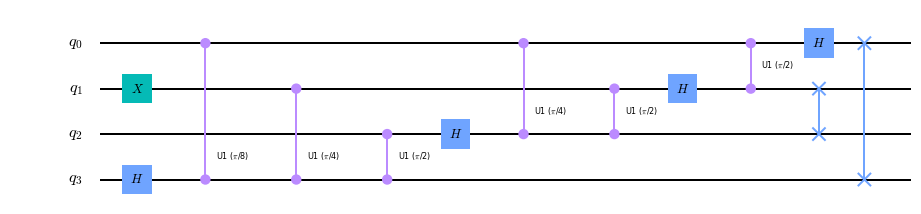

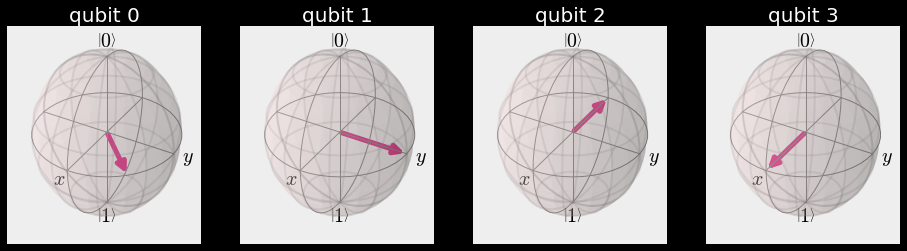

In [26]:
n = 4
qc = QuantumCircuit(n)
qc = init([3,2,1,0], '0010', qc)
qc = makeQFT(qc)

display(qc.draw('mpl'))
sim = Aer.get_backend('statevector_simulator')
result = execute(qc, sim, shots = 1).result()
display(plot_bloch_multivector(result.get_statevector()))

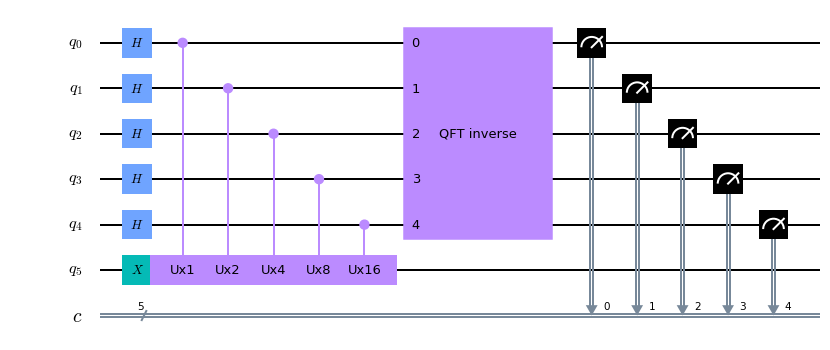

0.25 π


In [27]:
gate = QuantumCircuit(1)
gate.u1(np.pi/4, 0)
gate = gate.to_gate()
gate.name = 'U'

t = 5

initial_state = '10'

qc = getQPE(gate, t, initial_state, show_circuit = 0)

for i in range(t):
    qc.measure(i, i)
    
display(qc.draw('mpl'))

phase = calculate_phase(qc, 1)